# Engineering a training dataset
In this notebook we will create a dataset to train a regression model, and guess customer engagement with an uploaded recipe
The approach will be to create all these columns, and then cherry-pick the data we want to use to apply our different models in another notebook.

![table](../images/table-planning.jpg)


# We start shaping the MVP data


In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import datetime
from tqdm import tqdm 

start using RAW_interactions to score the interactions per recipes. 

In [2]:
interactions = pd.read_csv("../data/RAW_interactions.csv")
interactions

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [3]:
interactions.rename(columns={'date':'interaction_date'}, inplace=True)

In [4]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1132367 non-null  int64 
 1   recipe_id         1132367 non-null  int64 
 2   interaction_date  1132367 non-null  object
 3   rating            1132367 non-null  int64 
 4   review            1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


we need to use pandas_groupby to start calculating aggregations

In [5]:
recipes = pd.read_csv("../data/RAW_recipes.csv")
recipes.rename(columns={'id':'recipe_id'}, inplace=True)
recipes.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


As the database covers up to end of 2018 interactions, we will use 2018-12-31 as the reference day, as if we were doing this analysis then. 

In [6]:
REF_DAY = datetime.datetime(2018, 12, 31, 0, 0)

Now I want to bring over the subitted day of each recipe into the interaction dataset. 

In [7]:
submission_table = recipes[['recipe_id','submitted','contributor_id']]
submission_table

,recipe_id,submitted,contributor_id
0,137739,2005-09-16,47892
1,31490,2002-06-17,26278
2,112140,2005-02-25,196586
3,59389,2003-04-14,68585
4,44061,2002-10-25,41706
...,...,...,...
231632,486161,2012-08-29,227978
231633,493372,2013-01-09,1500678
231634,308080,2008-06-07,37779
231635,298512,2008-04-15,506822


In [8]:
interactions = interactions.merge(submission_table, on='recipe_id')
interactions

,user_id,recipe_id,interaction_date,rating,review,submitted,contributor_id
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2002-09-21,1533
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2002-09-21,1533
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2002-10-27,56824
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2004-02-25,64342
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2004-02-25,64342
...,...,...,...,...,...,...,...
1132362,417131,241491,2007-09-05,4,I made this over the weekend and changed it up...,2007-07-19,65197
1132363,648540,241491,2010-09-06,5,"Fabulous! We are vegetarian, so I used vegetar...",2007-07-19,65197
1132364,1269180,257796,2011-08-07,4,Very tender and juicy - had trouble getting t...,2007-10-08,140981
1132365,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,2003-10-06,103078


In [9]:
interactions['interaction_date'] = pd.to_datetime(interactions['interaction_date'])
interactions['submitted'] = pd.to_datetime(interactions['submitted'])

In [10]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   recipe_id         1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 69.1+ MB


In [11]:
interactions['days_after_sub'] = interactions['interaction_date']-interactions['submitted']
interactions['days_after_sub'] = [d.days for d in interactions['days_after_sub']]

In [12]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   recipe_id         1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
 7   days_after_sub    1132367 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 77.8+ MB


In [13]:
interactions

,user_id,recipe_id,interaction_date,rating,review,submitted,contributor_id,days_after_sub
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2002-09-21,1533,149
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2002-09-21,1533,3378
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2002-10-27,56824,35
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2004-02-25,64342,2194
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2004-02-25,64342,2775
...,...,...,...,...,...,...,...,...
1132362,417131,241491,2007-09-05,4,I made this over the weekend and changed it up...,2007-07-19,65197,48
1132363,648540,241491,2010-09-06,5,"Fabulous! We are vegetarian, so I used vegetar...",2007-07-19,65197,1145
1132364,1269180,257796,2011-08-07,4,Very tender and juicy - had trouble getting t...,2007-10-08,140981,1399
1132365,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,2003-10-06,103078,64


We will do the sentiment analysis now before calculating these aggregations 

In [14]:
from textblob import TextBlob

In [15]:
pol = lambda x: TextBlob(x).polarity

In [16]:
# this takes a while to go through the whole column
interactions['review_pol'] = [pol(str(rev)) for rev in tqdm(interactions['review'])]

100%|██████████| 1132367/1132367 [07:46<00:00, 2426.26it/s]


In [17]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   recipe_id         1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
 7   days_after_sub    1132367 non-null  int64         
 8   review_pol        1132367 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(5), object(1)
memory usage: 86.4+ MB


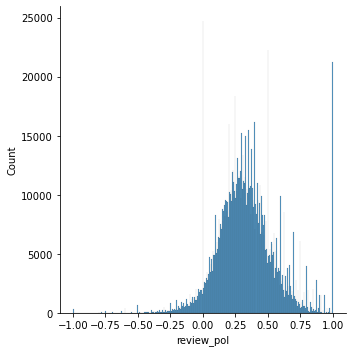

In [18]:
sns.displot(interactions['review_pol']);

In [19]:
interactions = interactions[['recipe_id',
                             'user_id',
                             'review',
                             'rating',
                             'interaction_date',
                             'submitted',
                             'contributor_id',
                             'days_after_sub',
                             'review_pol']]
interactions

,recipe_id,user_id,review,rating,interaction_date,submitted,contributor_id,days_after_sub,review_pol
0,40893,38094,Great with a salad. Cooked on top of stove for...,4,2003-02-17,2002-09-21,1533,149,0.270000
1,40893,1293707,"So simple, so delicious! Great for chilly fall...",5,2011-12-21,2002-09-21,1533,3378,0.242857
2,44394,8937,This worked very well and is EASY. I used not...,4,2002-12-01,2002-10-27,56824,35,0.366667
3,85009,126440,I made the Mexican topping and took it to bunk...,5,2010-02-27,2004-02-25,64342,2194,0.350000
4,85009,57222,"Made the cheddar bacon topping, adding a sprin...",5,2011-10-01,2004-02-25,64342,2775,-0.208333
...,...,...,...,...,...,...,...,...,...
1132362,241491,417131,I made this over the weekend and changed it up...,4,2007-09-05,2007-07-19,65197,48,-0.184375
1132363,241491,648540,"Fabulous! We are vegetarian, so I used vegetar...",5,2010-09-06,2007-07-19,65197,1145,0.277500
1132364,257796,1269180,Very tender and juicy - had trouble getting t...,4,2011-08-07,2007-10-08,140981,1399,-0.127083
1132365,72730,116593,Another approach is to start making sauce with...,0,2003-12-09,2003-10-06,103078,64,0.300000


Save in a clean dataframe to be used later in tableau for more exploratory analysis

In [20]:
interactions.to_csv("../data/clean-data/interactions_clean.csv")

Now we calculate aggregations in order to enrich the recipe dataframe

In [21]:
#Checkpoint to retake the notebook from this point
interactions = pd.read_csv("../data/clean-data/interactions_clean.csv")

In [22]:
interaction_nums = interactions[['recipe_id','user_id','rating','days_after_sub','review_pol']]

In [23]:
interaction_nums

,recipe_id,user_id,rating,days_after_sub,review_pol
0,40893,38094,4,149,0.270000
1,40893,1293707,5,3378,0.242857
2,44394,8937,4,35,0.366667
3,85009,126440,5,2194,0.350000
4,85009,57222,5,2775,-0.208333
...,...,...,...,...,...
1132362,241491,417131,4,48,-0.184375
1132363,241491,648540,5,1145,0.277500
1132364,257796,1269180,4,1399,-0.127083
1132365,72730,116593,0,64,0.300000


We aggregate by RECIPE ID, to add parameters about user interaction to each recipe

In [24]:
interact_agg = interaction_nums.groupby('recipe_id').agg({'user_id':'count',
                                                          'rating':'mean',
                                                          'days_after_sub':['max','min','mean'],
                                                          'review_pol':'mean'})

We want to create new column names to flatten the 2 dimensional columns name 

In [25]:
interact_agg.columns = ['_'.join(col).strip() for col in interact_agg.columns.values]
interact_agg.columns

Index(['user_id_count', 'rating_mean', 'days_after_sub_max',
       'days_after_sub_min', 'days_after_sub_mean', 'review_pol_mean'],
      dtype='object')

now we bring over the recipes again (in case the notebook was taken from the checkpoint)

In [26]:
recipes = pd.read_csv("../data/RAW_recipes.csv")
recipes.rename(columns={'id':'recipe_id'}, inplace=True)
recipes.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [27]:
combined_df = pd.merge(recipes, interact_agg, how='left', on='recipe_id')

In [28]:
combined_df.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id_count,rating_mean,days_after_sub_max,days_after_sub_min,days_after_sub_mean,review_pol_mean
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,3,5.0,2271,155,1408.666667,0.333095
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4,3.5,3219,63,1850.500000,0.453839
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,1,4.0,244,244,244.000000,0.569444
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,2,4.5,2193,1885,2039.000000,0.444015
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,1,5.0,3222,3222,3222.000000,0.285348


For the MVP we want to have a dataset with the following columns (descriptions are in the table at the top of this notebook): 

**recipe_id** (will be dropped before applying the model, we use it to track the recipe if we need to append things afterwards)  
**comm_rec_month** (dependant variable)  
**no_recipes_submitted**  
**avg_comments_recipes**  
**avg_ratings_recipes**  
**avg_sentiment_recipes**  
**time_to_cook**  
**no_steps**  
**no_ingredients**  
**nutrition_score**
**weekday_posted**
**month_posted**

In [29]:
combined_df['submitted'] = pd.to_datetime(combined_df['submitted'])

In [30]:
combined_df['days_since_posted'] = [d.days for d in REF_DAY - combined_df['submitted']]

In [31]:
combined_df['comm_rec_month'] = combined_df['user_id_count']/combined_df['days_since_posted']*30

For the columns coming from user data, we need to make some aggregations in the dataset

In [32]:
recipe_agg = combined_df.groupby('contributor_id').agg({'recipe_id':'count',
                                                        'user_id_count':'mean',
                                                        'rating_mean':'mean',
                                                        'review_pol_mean':'mean',
                                                        })

In [33]:
recipe_agg

,recipe_id,user_id_count,rating_mean,review_pol_mean
contributor_id,,,,
27,5,16.400000,3.879483,0.293479
1530,42,8.214286,4.186482,0.332973
1531,4,2.750000,4.775000,0.394319
1533,1595,3.554232,4.302731,0.321386
1534,297,6.353535,3.985190,0.324836
...,...,...,...,...
2002234364,1,1.000000,0.000000,-0.031181
2002234769,1,1.000000,0.000000,0.175000
2002247884,1,4.000000,0.000000,0.100608


In [34]:
recipe_agg.rename(columns = {'recipe_id':'no_recipes_submitted',
                             'user_id_count':'avg_comments_recipes',
                             'rating_mean':'avg_ratings_recipes',
                             'review_pol_mean':'avg_sentiment_recipes'
                             }, inplace=True)

In [35]:
recipe_agg

,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes
contributor_id,,,,
27,5,16.400000,3.879483,0.293479
1530,42,8.214286,4.186482,0.332973
1531,4,2.750000,4.775000,0.394319
1533,1595,3.554232,4.302731,0.321386
1534,297,6.353535,3.985190,0.324836
...,...,...,...,...
2002234364,1,1.000000,0.000000,-0.031181
2002234769,1,1.000000,0.000000,0.175000
2002247884,1,4.000000,0.000000,0.100608


In [36]:
combined_df = pd.merge(combined_df, recipe_agg, how='left', on=['contributor_id'])

In [37]:
combined_df.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,days_after_sub_max,days_after_sub_min,days_after_sub_mean,review_pol_mean,days_since_posted,comm_rec_month,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,2271,155,1408.666667,0.333095,4854,0.018541,735,3.068027,4.596259,0.327186
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,3219,63,1850.500000,0.453839,6041,0.019864,366,5.669399,4.324293,0.320801
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,244,244,244.000000,0.569444,5057,0.005932,7,1.428571,4.714286,0.410158
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,2193,1885,2039.000000,0.444015,5740,0.010453,115,3.721739,4.369417,0.327694
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,3222,3222,3222.000000,0.285348,5911,0.005075,91,9.725275,4.375281,0.310879


In [38]:
combined_df.columns

Index(['name', 'recipe_id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'user_id_count', 'rating_mean', 'days_after_sub_max',
       'days_after_sub_min', 'days_after_sub_mean', 'review_pol_mean',
       'days_since_posted', 'comm_rec_month', 'no_recipes_submitted',
       'avg_comments_recipes', 'avg_ratings_recipes', 'avg_sentiment_recipes'],
      dtype='object')

# Steps after MVP
## Using spacy to find verbs in the steps and giving a difficulty 

Knowing our context is recipes, we expect to find a limited number of verbs that will describe different actions and techniques. we will see most common verbs we can find, and we will consider recipes with low or no verbs to be simpler than others that have more verbs into more complex recipes. 

In [39]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [40]:
verbs_set = set()

In [41]:
for prep in tqdm(combined_df['steps'].sample(3000)):
    doc = nlp(prep)
    verbs = [token.text for token in doc if token.pos_=="VERB"]
    for verb in verbs:
        verbs_set.add(verb)
        


100%|██████████| 3000/3000 [00:54<00:00, 55.53it/s]


In [42]:
print(verbs_set)

{'hardboiled', 'contains', 'store', 'turning', 'deal', 'stripped', 'coming', 'rests', 'brush', 'mush', 'filled', 'pushing', 'firm', 'totaling', 'epazote', 'result', 'featuring', 'meets', 'devein', 'packaged', 'sample', 'grated', 'weigh', 'enable', 'assemble', 'aiming', 'occur', 'bast', 'load', 'curled', 'trimmed', 'lighten', 'griddle', 'sliding', 'satisfaction', 'seasoned', 'mound', 'swap', 'deglaze', 'emulsified', 'squirt', 'doneness', 'sweetened', 'vegetarian', 'line', 'invented', 'shimmering', 'piped', 'bun', 'powdered', 'roquefort', 'fry', 'googling', 'reduces', 'chilling', 'referred', 'let', 'mashing', 'creating', 'keep', 'passed', 'fill', 'google', 'found', 'clams', 'does', 'lke', 'zest', 'mixed', 'brown', 'using', 'blanched', 'collapse', 'says', 'pairing', 'flaten', 'freeze', 'cannellini', 'papered', 'ladled', 'step', 'seen', 'serrated', 'start', "'re", 'smoothing', 'granulted', 'relieve', 'bought', 'scooped', 'mins', 'crumble', 'recommended', 'microwave', 'prodded', 'wire', 'fr

This won't work without a more specific definition of what are verbs that correspond to cooking techniques in a kitchen. also spacy will detect several ingredient names as verbs, so we'll leave the complexity of the recipe to the column no_steps only and we will focus in creating categories with the tags. 

## Find all tags from all recipes and decide if we want to extract categories from them 

In [43]:
tags_set = set()
for tags in combined_df['tags'].sample(10):
        print (tags)

['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'breakfast', 'casseroles', 'main-dish', 'eggs-dairy', 'pork', 'american', 'southwestern-united-states', 'tex-mex', 'oven', 'easy', 'beginner-cook', 'potluck', 'dinner-party', 'cheese', 'eggs', 'dietary', 'spicy', 'one-dish-meal', 'comfort-food', 'inexpensive', 'meat', 'taste-mood', 'to-go', 'equipment']
['weeknight', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'lunch', 'main-dish', 'pork', 'poultry', 'rice', 'spanish', 'easy', 'european', 'kid-friendly', 'portuguese', 'chicken', 'dietary', 'one-dish-meal', 'comfort-food', 'oamc-freezer-make-ahead', 'meat', 'pork-sausage', 'pasta-rice-and-grains', 'taste-mood', '4-hours-or-less']
['weeknight', '30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'appetizers', 'seafood', 'australian', 'dinner-party', 'shrimp', 'food-processor-

In [44]:
tags_set = set()

In [45]:
tags_set = set()
for row_tags in tqdm(combined_df['tags']):
    for tag in [a.strip("' ") for a in row_tags.strip("[]").split(",")]:
        tags_set.add(tag)

100%|██████████| 231637/231637 [00:01<00:00, 145981.95it/s]


In [46]:
len(tags_set)

552

In [47]:
tags_set

{'',
 '1-day-or-more',
 '15-minutes-or-less',
 '3-steps-or-less',
 '30-minutes-or-less',
 '4-hours-or-less',
 '5-ingredients-or-less',
 '60-minutes-or-less',
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.',
 'a1-sauce',
 'african',
 'american',
 'amish-mennonite',
 'angolan',
 'appetizers',
 'apples',
 'april-fools-day',
 'argentine',
 'artichoke',
 'asian',
 'asparagus',
 'australian',
 'austrian',
 'avocado',
 'bacon',
 'baja',
 'baked-beans',
 'baking',
 'bananas',
 'bar-cookies',
 'barbecue',
 'bass',
 'bean-soup',
 'beans',
 'beans-side-dishes',
 'bear',
 'beef',
 'beef-barley-soup',
 'beef-crock-pot',
 'beef-kidney',
 'beef-liver',
 'beef-organ-meats',
 'beef-ribs',
 'beef-sauces',
 'beef-sausage',
 'beginner-cook',
 'beijing',
 'belgian',
 'berries',
 'beverages',
 'birthday',
 'biscotti',
 'bisques-cream-soups',
 'black-bean-soup',
 'black-beans',
 'blueberries',
 'bok-choys',
 'brazilian',
 'bread-machine',
 'bread-pudding',
 'breads',
 'breakfast',
 '

In [48]:
categories=['appetizers',
            'baking',
            'barbecue',
            'desserts',
            
            'breakfast',
            'brunch',
            'lunch',
            'cocktails',
            'dinner-party',
            
            'meat',
            'vegan',
            'vegetarian',
            
            'spicy',
            
            'low-carb',
            'low-fat',
            'low-protein',
            'low-sodium',
            'nut-free',
            'egg-free',
            'dairy-free',
            'gluten-free',
            
            'microwave',
            'easy',
            'no-cook',
            'deep-fry',
            
            'pasta',
            'pizza',
            'cupcakes',
            'muffins',
            'macaroni-and-cheese',
            
            'peanut-butter',
            'vegetables',
            'fruit',
            'bacon',
            'avocado',                       
            'cheese',
            'chocolate',
            ]

In [49]:
len(categories)

37

In [ ]:
combined_df.to_csv("../data/clean-data/recipes_combined_clean.csv")

* and we create a dataframe with dummies regarding these categories:  

**WARNING this will take several hours to go through all 200k+ recipes**  

If you don't want to wait, go to the next checkpoint and load the dataframe, as these columns wont be used anymore in this notebook

In [ ]:
categories_df = pd.DataFrame(columns=categories)

In [ ]:

for i,tags in tqdm(enumerate(combined_df['tags'])):
    row = []
    for cat in categories:
        if cat in tags:
            row.append(1)
        else:
            row.append(0)
    categories_df.loc[i] = row


In [ ]:
categories_df

In [ ]:
combined_df = pd.concat([combined_df,categories_df], axis =1)

We save this dataframe to recall it in other iterations.

In [50]:
combined_df.to_csv("../data/clean-data/recipes_combined_clean.csv")

In [51]:
#Checkpoint to retake the notebook from this point
combined_df = pd.read_csv("../data/clean-data/recipes_combined_clean.csv", index_col=0)

In [52]:
combined_df.columns

Index(['name', 'recipe_id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'user_id_count', 'rating_mean', 'days_after_sub_max',
       'days_after_sub_min', 'days_after_sub_mean', 'review_pol_mean',
       'days_since_posted', 'comm_rec_month', 'no_recipes_submitted',
       'avg_comments_recipes', 'avg_ratings_recipes', 'avg_sentiment_recipes'],
      dtype='object')

## Generating new dependent variables
The first dependent variable we chose is too small to become a tangible parameter, and even due it does give insight on how much traffic our recipe might attract to our page, it is very unpredictable when people will actually interact with the recipe further away than a few days after the posting.   
Because of this, we will change the focus and try to measure the number of interactions the posted recipe has **only during the 30 days after the recipe was posted**. We will also generate a new column with the average rating of the recipe, for further applications of the model.
* We first check both submitted date and interaction date are in interactions dataframe

In [53]:
interactions.dtypes

Unnamed: 0            int64
recipe_id             int64
user_id               int64
review               object
rating                int64
interaction_date     object
submitted            object
contributor_id        int64
days_after_sub        int64
review_pol          float64
dtype: object

* Then turn our date columns into datetime types

In [54]:
interactions['interaction_date'] = pd.to_datetime(interactions['interaction_date'])
interactions['submitted'] = pd.to_datetime(interactions['submitted'])


* Now we can create a column that is true when the comment is inside the first seven days since posted

In [55]:
interactions['in_first30d'] = interactions['interaction_date']<interactions['submitted']+datetime.timedelta(days=30)

In [56]:
interactions['in_first30d'].value_counts()

False    1045848
True       86519
Name: in_first30d, dtype: int64

In [57]:
in_first_month = interactions.groupby('recipe_id').agg({'in_first30d':'count',
                                                   'rating':'mean'})

In [58]:
combined_df = combined_df.merge(in_first_month, how='left', on='recipe_id')

In [59]:
 combined_df.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,days_after_sub_mean,review_pol_mean,days_since_posted,comm_rec_month,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes,in_first30d,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,1408.666667,0.333095,4854,0.018541,735,3.068027,4.596259,0.327186,3,5.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,1850.500000,0.453839,6041,0.019864,366,5.669399,4.324293,0.320801,4,3.5
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,244.000000,0.569444,5057,0.005932,7,1.428571,4.714286,0.410158,1,4.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,2039.000000,0.444015,5740,0.010453,115,3.721739,4.369417,0.327694,2,4.5
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,3222.000000,0.285348,5911,0.005075,91,9.725275,4.375281,0.310879,1,5.0


And we save this resulting dataframe again 

In [60]:
combined_df.to_csv("../data/clean-data/recipes_combined_clean.csv")

## Making a dataframe for the regression models 

In [61]:
#Checkpoint to retake the notebook from this point
combined_df = pd.read_csv("../data/clean-data/recipes_combined_clean.csv", index_col=0)

In [62]:
combined_df['submitted'] = pd.to_datetime(combined_df['submitted'])

In [63]:
combined_df['month_posted'] = [d.month for d in combined_df['submitted']]

Now we need the columns from recipe. time_to_cook, no_steps and no_ingredients are already on the table, let's try to get a nutrition score, as well as the weekday and month on which the recipe was posted 

In [64]:
combined_df.columns

Index(['name', 'recipe_id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'user_id_count', 'rating_mean', 'days_after_sub_max',
       'days_after_sub_min', 'days_after_sub_mean', 'review_pol_mean',
       'days_since_posted', 'comm_rec_month', 'no_recipes_submitted',
       'avg_comments_recipes', 'avg_ratings_recipes', 'avg_sentiment_recipes',
       'in_first30d', 'rating', 'month_posted'],
      dtype='object')

In [65]:
MVP_export = combined_df[['recipe_id',
                        'comm_rec_month',
                        'in_first30d',
                        'rating',
                        'no_recipes_submitted',
                        'avg_comments_recipes',
                        'avg_ratings_recipes',
                        'avg_sentiment_recipes',
                        'minutes',
                        'n_steps',
                        'n_ingredients',
                        'month_posted',
                        'days_since_posted']]

In [66]:
MVP_export.to_csv("../data/mvp_export.csv")